In [1]:


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
     


In [2]:
# Load data into DataFrame 
data = pd.read_csv('df_KO_.csv',parse_dates=True, index_col=0)

In [3]:
data

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E
Date,,,,,,,,,,,,,,,,,,
1996-05-06,19.937500,20.218750,19.750000,20.218750,10.236874,7170400,0.14,0.281250,54.166667,70.000000,20.167723,20.122550,0.045173,0.045976,-0.000803,-0.154321,-10631600,144.419643
1996-05-07,20.218750,20.406250,20.156250,20.343750,10.300159,6702800,0.14,0.125000,56.578947,83.333333,20.194804,20.138935,0.055869,0.047955,0.007914,1.244168,-3928800,145.312500
1996-05-08,20.343750,20.687500,20.062500,20.687500,10.474213,8292800,0.14,0.343750,65.853659,100.000000,20.270603,20.179569,0.091034,0.056571,0.034463,1.846154,4364000,147.767857
1996-05-09,20.687500,20.937500,20.593750,20.687500,10.474213,4820400,0.14,0.000000,71.052632,78.947368,20.334741,20.217194,0.117547,0.068766,0.048781,1.846154,4364000,147.767857
1996-05-10,20.718750,20.968750,20.718750,20.968750,10.616608,4942800,0.14,0.281250,68.571429,100.000000,20.432281,20.272865,0.159416,0.086896,0.072520,3.389831,9306800,149.776786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,62.855492,6463300,0.69,0.480000,53.333314,62.869238,63.351839,62.744877,0.606962,0.768770,-0.161808,-0.234487,3006553500,92.492753
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.239597,7320700,0.69,0.389999,56.862744,79.324942,63.483864,62.853404,0.630459,0.741108,-0.110649,0.343800,3013874200,93.057970
2022-12-28,64.459999,64.650002,63.490002,63.570000,62.609272,7159400,0.69,-0.639999,50.243892,52.320693,63.497115,62.906485,0.590630,0.711012,-0.120382,-0.656356,3006714800,92.130434


In [6]:
data['y'] = data['Close']

In [7]:
x = data.iloc[:, :18].values
y = data.iloc[:, 18].values

In [8]:
x

array([[ 1.99375000e+01,  2.02187500e+01,  1.97500000e+01, ...,
        -1.54320988e-01, -1.06316000e+07,  1.44419643e+02],
       [ 2.02187500e+01,  2.04062500e+01,  2.01562500e+01, ...,
         1.24416796e+00, -3.92880000e+06,  1.45312500e+02],
       [ 2.03437500e+01,  2.06875000e+01,  2.00625000e+01, ...,
         1.84615385e+00,  4.36400000e+06,  1.47767857e+02],
       ...,
       [ 6.44599991e+01,  6.46500015e+01,  6.34900017e+01, ...,
        -6.56355638e-01,  3.00671480e+09,  9.21304343e+01],
       [ 6.37999992e+01,  6.41500015e+01,  6.37000008e+01, ...,
         1.33100958e+00,  3.01388410e+09,  9.26811605e+01],
       [ 6.39199982e+01,  6.39199982e+01,  6.31699982e+01, ...,
         1.37051890e+00,  3.00623390e+09,  9.21884067e+01]])

In [9]:
y

array([20.21875   , 20.34375   , 20.6875    , ..., 63.56999969,
       63.95000076, 63.61000061])

In [10]:
split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (5368, 18) trainY: (5368,)
testX: (1343, 18) testY: (1343,)


In [11]:


def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan
     


In [12]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([5365, 3, 18]) train_y: torch.Size([5365, 1]) train_y_gan: torch.Size([5365, 4, 1])
test_x: torch.Size([1340, 3, 18]) test_y: torch.Size([1340, 1]) test_y_gan: torch.Size([1340, 4, 1])


In [13]:

class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [14]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)


modelG = Generator(18).to(device) # Updated input size
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')
     

[1/165] LossD: 58.22434949874878 LossG:29.12159788608551
[2/165] LossD: 58.22364342212677 LossG:29.113424479961395
[3/165] LossD: 58.22294044494629 LossG:29.114380836486816
[4/165] LossD: 58.22137427330017 LossG:29.11599886417389
[5/165] LossD: 58.220229506492615 LossG:29.11647540330887
[6/165] LossD: 58.21807777881622 LossG:29.118367910385132
[7/165] LossD: 58.21466088294983 LossG:29.121634244918823
[8/165] LossD: 58.20951724052429 LossG:29.125861704349518
[9/165] LossD: 58.20271277427673 LossG:29.132493317127228
[10/165] LossD: 58.19804084300995 LossG:29.135700166225433
[11/165] LossD: 58.18185901641846 LossG:29.145648300647736
[12/165] LossD: 58.16857659816742 LossG:29.1616553068161
[13/165] LossD: 58.15025186538696 LossG:29.180022478103638
[14/165] LossD: 58.12680721282959 LossG:29.2014063000679
[15/165] LossD: 58.10090923309326 LossG:29.224444687366486
[16/165] LossD: 58.0718435049057 LossG:29.25028097629547
[17/165] LossD: 58.027411103248596 LossG:29.283260226249695
[18/165] Loss

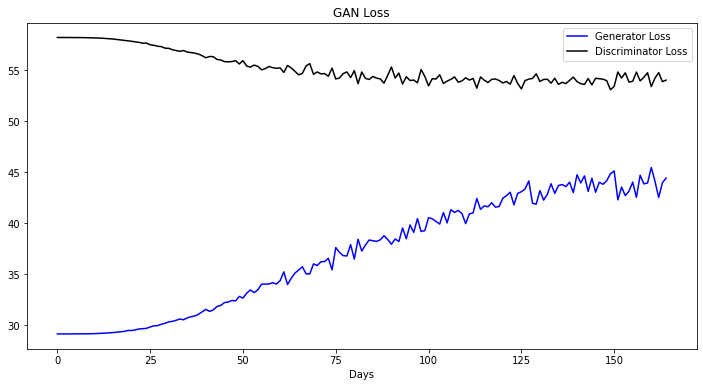

In [15]:


plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
     


Training dataset RMSE:0.6855697273587352


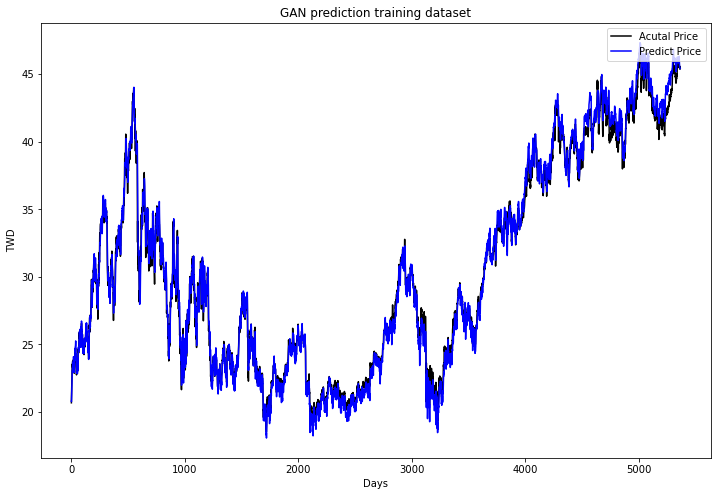

In [16]:


modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())
     

plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')
     


Training dataset RMSE:4.667156532955023


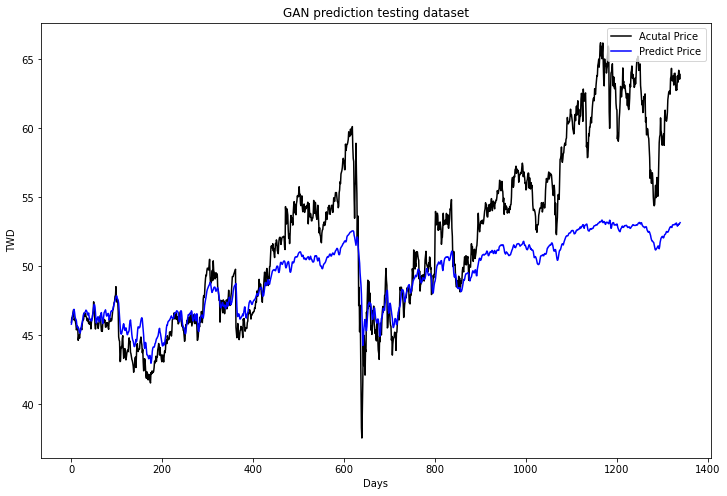

In [17]:


plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')
     
